# Application 2: Simple NLP machine learning models
Now, we look at our first models to classify the data into "raining" and "not raining". A crucial first step in NLP is always to find numerical representations of our words to use them in a machine learning model. We will encounter two different methods here. As our mode, we rely on a "simple" [recurrent neural network](https://d2l.ai/chapter_recurrent-neural-networks/index.html) (RNN) here, which relies on a [Long Short-Term memory (LSTM)](https://d2l.ai/chapter_recurrent-modern/lstm.html) layer. The links provided, give a very concise introduction to RNNs in general and popular models. We won't have time to understand them in detail during the course but feel free to explore the linked sites by yourself. The basic idea behind RNNs is that you make predictions depending on a trained hidden state that works as the "memory" of the model. 

In [1]:
# allows update of external libraries without need to reload package
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import sklearn.model_selection
import sklearn.preprocessing
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
import keras.preprocessing.text
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import xarray

%matplotlib inline

import sys

sys.path.append("../scripts")
import normalize_text_bootcamp
import utils_bootcamp
import plotting

2023-11-03 11:37:25.376922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 11:37:26.881596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Exercise 0: Load the data

In [12]:
FOLDER_DATA = "/p/scratch/deepacf/maelstrom/maelstrom_data/ap2/data/tweets/"
FOLDER_DATA = "/p/project/training2223/a2/data/tweets/"
FOLDER_DATA = "/p/project/deepacf/maelstrom/haque1/dataset/"


In [15]:
FOLDER_TWEET = FOLDER_DATA + "20_percent_2017_2020_tweets_rain_sun_vocab_emojis_locations_bba_Tp_era5_no_bots_normalized_filtered_weather_stations_fix_predicted_simpledeberta_radar.nc"
# define the variable name of the total precipitation in the dataset
key_tp = "tp_h"
ds = xarray.load_dataset(FOLDER_TWEET)

In [16]:
ds

<xarray.Dataset>
Dimensions:                             (index: 121860)
Coordinates:
  * index                               (index) int64 484051 106155 ... 10039
Data variables: (12/58)
    text                                (index) object 'As the sun goes down,...
    conversation_id                     (index) object '986671498382454790' ....
    lang                                (index) object 'en' 'en' ... 'en' 'en'
    reply_settings                      (index) object 'everyone' ... 'everyone'
    source                              (index) object 'Instagram' ... 'Twitt...
    author_id                           (index) object '20773923' ... '210208...
    ...                                  ...
    x_ngt_rounded                       (index) float64 5.285e+05 ... 2.345e+05
    y_ngt_rounded                       (index) float64 1.805e+05 ... 6.545e+05
    time_radar                          (index) datetime64[ns] 2018-04-18T18:...
    tp_mm_radar                         (index) float64 0.0 0.0 0.0 ... 0.0 0.0
    time_radar_int                      (index) int64 1524075900000000000 ......
    created_at_rounded_5                (index) datetime64[ns] 2018-04-18T18:...
Attributes:
    description:  added locationsadded locationsadded locationsadded location...

## Exercise 1: Normalization (should already be done at this point)
Depending on the state of the data we need to normalize it. It may also make sense to test different possibilities of normalizing the data. Our data is likely already normalized at this point. So, we skip it for now.

In [10]:
# ds_norm = normalize_text_bootcamp.normalize_filter_dataset(
#     ds,
#     keywords=None,
#     reset_index=True,
#     key_text_original="text_original",
#     key_text_normalized="text_normalized",
#     key_text_backup=None,
#     ignore_non_ascii=True,
#     replace_keyword_emojis=True,
#     remove_punctuations="keep_basic_punctuations",
#     reduce_punctuations=True,
#     use_lower_case=True,
#     do_split_punctutation_text=False,
#     remove_sun_confusing_terms=True,
#     only_text_containing_keywords=True,
#     maximum_bounding_box_area=100,
# )

## Exercise 2: Preparation for training (probably not required)
Prepare data for training
Before we actually train our model, we need to

* define our labels
* encode our labels
* encode our Tweets into "numbers" (vectors)
* split our data into a training and test set
* define the model

### Define labels
We first define our labels, based on our total precipitation values. By default, we use a threshold of roughly machine precision of the underlying weather forecasting model. However, higher thresholds should be tested in the future to check what Twitter users consider to be "rain".

In [17]:
ds["raining"] = (["index"], ds[key_tp].values > 1e-8)

### Define our input and output variables as an array
Following the tradition, we define our input variables to the model (normalized text of the Tweets) as `X` and our labels as `Y`.

In [7]:
X = ds.text_normalized.values
Y = ds.raining.values

### Split training and test set
We use `sklearn.model_selection.train_test_split` to split the model.

### Task:
* We would like to use 80% of the Tweets for training and 20% for testing.
* Make sure that both labels are represented in the proportions both in the test and training set. The argument `stratify` of the function `sklearn.model_selection.train_test_split` may help. Check the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for details.

In [8]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    X,
    Y,
    test_size=0.15,
    # "stratify= ...",
)

### Encode our labels 
This step is required if our label's are in text format (e.g., "cat", "dog"). This is not the case here, but it's included for completion. The format of encoded labels depends on the model, so you should check them as well.

In [9]:
le = sklearn.preprocessing.LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1, 1)

In [10]:
X

array(['still got my lightning ar that is it tho',
       'Another lap around the sun. Good work people.',
       'Happy sun with face sun with face sun with face', ...,
       'It is the reverse of being draped over a sun lounger',
       'A very picturesque light dusting of snow plus is creating a thrilling atmosphere. I am in bed, cozy under my duvet with dogs on top of the duvet.',
       'This is the most surreal NYE that I have ever known. Not a car track in the snow at nearly'],
      dtype=object)

In [11]:
Y

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

### **Tokenization of the data**
Texts have to be broken down into smaller chunks so called "tokens", which are then encoded as vectors in the next. Many implementations of tokenization exist. Here, we will use the default `keras` implementation. For a sentence like "Today will be a sunny day!", you can imagine just ascribing every individual word a token. However, for a sentence like "I wouldn't enjoy a sunny day by programming in C++". Here, tokenizing "wouldn't" is not as straightforward. You probably would like to retain the "would" and the "not" part, so maybe just replacing this word by the long form of the word would be an option. In addition, "C++" is by itself a weird combination of a letter and mathematical symbols that you would probably filter out when looking at text. However, the word itself is of course referring to a programming language, which means it should probably be used as a single token. In the next notebook, we will encounter a more complex tokenizer, which is called [sentence-piece](https://jacky2wong.medium.com/understanding-sentencepiece-under-standing-sentence-piece-ac8da59f6b08).

In [12]:
max_words = 1000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_words)

### **Encoding of the tokens**
We now use
* the method `fit_on_texts` to connect each token to a unique integer, which will be used for encoding
* the method `texts_to_sequences` to encode every Tweet by tokenizing the Tweet and ascribing its unique integer (from the previous step) to the token
* the method `pad_sequences` to "pad" our encoded Tweets such that they all have the same length (`max_len`), which is required by the model architecture.

In [13]:
max_len = 100
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

## Model definition
The model is defined via different layers taken from Keras. [Keras](https://keras.io/getting_started/intro_to_keras_for_researchers/) is a high level API based on TensorFLow. It contains the following layers:

* Input layer: accepts our encoded Tweets where each Tweet has the length `max_len`
* Embedding layer: trained representation of our encoded Tweets. Currently, our Tweets are encoded as integer values, however neural networks operate with float values usually in the range around -1 to 1, so we would like to present each token as a vector with values in this range. An embedding layer is used for this. We set `output_dim=50`, which means that every token will be represented by a vector of length 50. In addition, its weights (so the representation of individual tokens) are trained when training the model. See [small intro](https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce) or [on stack overflow](https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work/305032#305032).
* LSTM layer: The so called Long short-term memory is used in many reccurent neural networks. See links in the introduction to this notebook.
* Dense layer: Most basic layer of NN, see [intro here](http://www2.cs.uregina.ca/~dbd/cs831/notes/neural-networks/neural-networks/) for more details.
* Activation function: The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.
* Dropout layer: The Dropout layer randomly removes neurons from the network with a frequency of rate at each step during training time, which helps prevent overfitting.
* Dense layer: See above
* Activation function: sigmoid function, which converts previous outputs to probabilities (add up to 1)

In [15]:
def RNN():
    inputs = Input(name="inputs", shape=[max_len])
    layer = Embedding(max_words, output_dim=50, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name="FC1")(layer)
    layer = Activation("relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name="out_layer")(layer)
    layer = Activation("sigmoid")(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [16]:
model = RNN()
model.summary()
model.compile(loss="binary_crossentropy", optimizer=RMSprop(), metrics=["accuracy"])

2023-11-01 12:06:43.838387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38553 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-11-01 12:06:43.839118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38553 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:44:00.0, compute capability: 8.0
2023-11-01 12:06:43.839677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38553 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:84:00.0, compute capability: 8.0
2023-11-01 12:06:43.840177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38553 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

## Exercise 3: Model training
We train our model with a batch size of 128 (amount of data passed simultaneously through the network).

In [17]:
model.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10,
)

Epoch 1/10


2023-11-01 12:06:53.278990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2023-11-01 12:06:53.796046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-01 12:06:54.630946: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x148e6ce545b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-01 12:06:54.630982: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-11-01 12:06:54.630988: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-11-01 12:06:54.630993: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-11-01 12:06:54.630998: I tensorflow/compil

8093/8093 [==============================] - 57s 6ms/step - loss: 0.6038 - accuracy: 0.6737
Epoch 2/10
8093/8093 [==============================] - 38s 5ms/step - loss: 0.5960 - accuracy: 0.6794
Epoch 3/10
8093/8093 [==============================] - 39s 5ms/step - loss: 0.5935 - accuracy: 0.6812
Epoch 4/10
8093/8093 [==============================] - 38s 5ms/step - loss: 0.5920 - accuracy: 0.6819
Epoch 5/10
8093/8093 [==============================] - 38s 5ms/step - loss: 0.5908 - accuracy: 0.6826
Epoch 6/10
8093/8093 [==============================] - 38s 5ms/step - loss: 0.5898 - accuracy: 0.6835
Epoch 7/10
8093/8093 [==============================] - 39s 5ms/step - loss: 0.5892 - accuracy: 0.6841
Epoch 8/10
8093/8093 [==============================] - 39s 5ms/step - loss: 0.5884 - accuracy: 0.6847
Epoch 9/10
8093/8093 [==============================] - 38s 5ms/step - loss: 0.5878 - accuracy: 0.6851
Epoch 10/10
8093/8093 [==============================] - 38s 5ms/step - loss: 0.5871

## Exercise 4: Testing the model

In [18]:
# build test dataset
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_matrix_test = pad_sequences(sequences_test, maxlen=max_len)

In [19]:
model.evaluate(sequences_matrix_test, Y_test)

5713/5713 [==============================] - 13s 2ms/step - loss: 0.5912 - accuracy: 0.6800


[0.5912224650382996, 0.6799531579017639]

## Further analysis
Let's now take a closer look at our results by looking at the so-called [f1-score](https://deepai.org/machine-learning-glossary-and-terms/f-score) and the AUC derived from the [ROC curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

In [20]:
Y_predict = model.predict(sequences_matrix_test)

5713/5713 [==============================] - 10s 2ms/step


In [21]:
Y_predict

array([[0.40521544],
       [0.556737  ],
       [0.67329127],
       ...,
       [0.41657352],
       [0.45783776],
       [0.78196996]], dtype=float32)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n not raining       1.00      0.44      0.61    182792\n     raining       0.00      0.00      0.00         0\n\n    accuracy                           0.44    182792\n   macro avg       0.50      0.22      0.30    182792\nweighted avg       1.00      0.44      0.61    182792\n'

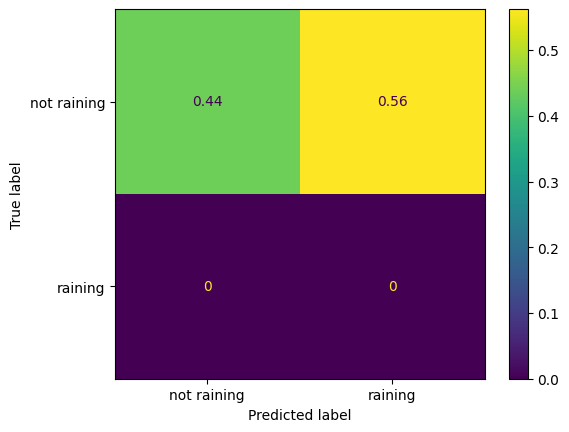

In [22]:
plotting.analysis.check_prediction(Y_predict.argmax(-1), Y_test)

In [23]:
plotting.analysis.classification_report(Y_predict.argmax(-1), Y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'not raining': {'precision': 1.0,
  'recall': 0.4376723270164996,
  'f1-score': 0.6088624212789436,
  'support': 182792.0},
 'raining': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 'accuracy': 0.4376723270164996,
 'macro avg': {'precision': 0.5,
  'recall': 0.2188361635082498,
  'f1-score': 0.3044312106394718,
  'support': 182792.0},
 'weighted avg': {'precision': 1.0,
  'recall': 0.4376723270164996,
  'f1-score': 0.6088624212789436,
  'support': 182792.0}}

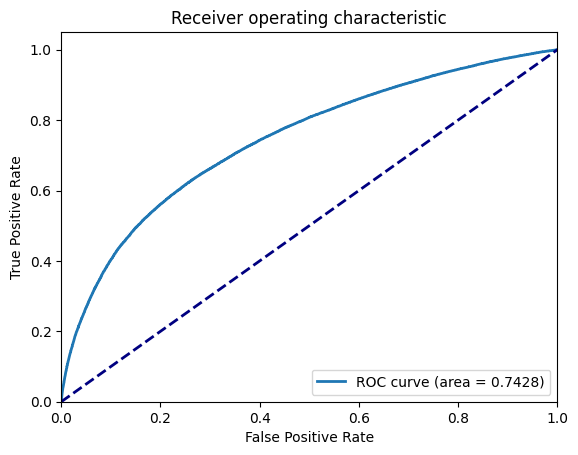

In [24]:
plotting.analysis.plot_roc(Y_test, Y_predict)

### Task:
* How come our accuracy on the test set is lower than the accuracy during training?
* Overcome this issue by introducing an early stopping mechanisms that stops when our validation accuracy stops improving at the 0.01% level. Use a `callbacks=EarlyStopping(monitor="val_loss", min_delta= ??? )` and `validation_split=0.2` for this.
* Why is the precision of "raining" zero? Did the model learn something? What do you think is a good measurement of the "quality" of our model?
* Vary the dropout rate? What happens?
* Add more layers to the network. If you do not where to start take a look at alternative LSTMs like [here](https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/). Can you manage to improve the results?